In [115]:
import sys, os
import importlib
from importlib import reload
# importlib.import_module(module_name)
sys.path.append("../../../python")

import matplotlib.pyplot as plt
import numpy as np
import scipy
import tqdm

from simhelper import util, root, generator, parser
from simhelper import datatypes
from simhelper import helper_basic as hp
reload(parser)
reload(datatypes)

np.set_printoptions(edgeitems=30, linewidth=100000, 
    precision=3)

## Commands

We first do a single run and check the distribution of generated particles 

```bash
# Make a new folder to save data for this test
data_dir=~/data/simulation/temp/musim_test/cosmic
# data_dir=~/data/simulation/temp/musim_test/cosmic
mkdir -p $data_dir
data_dir=`realpath $data_dir`
run=1

./_start_single_run.sh ~/geant_projects/mathusla-newsim $data_dir 100000 $run

# We run the tracker again to save all events, becasue the default setting in the above script only save events with upward vertex.
pushd ../../../build
./tracker $data_dir/run_${run}_digi.root -r $data_dir/run_${run}.root -k 0 -p 1000  
popd

```

Then we test scripts for a series of run, and for multiple series

```bash
# Run simulation + digitization + reconstruction
series=1
./_start_series_of_run.sh \
    -p `realpath ../../..` \
    -o $data_dir/series_$series
    -m $data_dir \
    -e 100000 \
    -r 3 \
    -s $series \
    -c y

bash _submit_series.sh -f cosmic_p/_start_series_of_run.sh \
    -m $data_dir \
    -e 100000 \
    -r 4 \
    -j 2 \
    -t 1 \
    -n cosmic_p
    -s Run    
```

In [162]:
data_dir="/home/tomren/geant_projects/musim_test/cosmic/"
fname_recon = f"{data_dir}/run_1_digi_recon.root"

In [206]:
f1 = root.tfile_reader(fname_recon)
f1.ls()
# f1.ls_tree()

## Get metadata
f1.get_tree("metadata;2")
metadata_digi = f1.get_entry(0)

f1.get_tree("metadata;3")
metadata_sim = f1.get_entry(0)

f1.get_tree("data")
# f1.ls_tree()
f1.get_entry(0);
print("Total entries:", f1.entries)

None
Total entries: 28892
TFile**		/home/tomren/geant_projects/musim_test/cosmic//run_1_digi_recon.root	
 TFile*		/home/tomren/geant_projects/musim_test/cosmic//run_1_digi_recon.root	
  KEY: TTree	data;3	Reconstruction Tree [current cycle]
  KEY: TTree	data;2	Reconstruction Tree [backup cycle]
  KEY: TTree	metadata;3	Simulation metadata [current cycle]
  KEY: TTree	metadata;2	Metadata for digitization [backup cycle]
  KEY: TTree	metadata;1	Metadata for reconstruction [backup cycle]


In [207]:
print(metadata_sim)

## We can see the flux [/cm2/s]:0.000580664

{'SimulationName': 'Mathusla simulation\n', 'Geometry': 'mu40v0\n', 'Generator': 'parma\n', 'Time': '2025-02-12 16:24:56\n', 'GenReserved1': 'flux [/cm2/s]:0.000580664', 'GenReserved2': '\x00', 'GenReserved3': '\x00', 'GenReserved4': '\x00'}


In [195]:
keys = ["digi_x", "digi_y", "digi_z", "digi_layer", "gen_x", "gen_y", "gen_z", "gen_px", "gen_py", "gen_pz", "residual_x", "residual_y", "residual_z", "residual_t", "direction", "det_id", "hit_x", "hit_y", "hit_z"] 
res = {key:[] for key in keys}

def process_digi(data):
    data["Digi_hitInds_split"] = parser.unpack_at(data["Digi_hitInds"], -1)

isbreak=False
for i in tqdm.tqdm(range(f1.entries)):
    data_digi = data_raw = f1.get_entry(i)
    process_digi(data_digi)


    for j in range(len(data_digi["Digi_x"])):
        raw_ind = data_digi["Digi_hitInds_split"][j][0]
        if raw_ind==9999999:
            continue        
        res["digi_x"].append(data_digi["Digi_x"][j])
        res["digi_y"].append(data_digi["Digi_y"][j])
        res["digi_z"].append(data_digi["Digi_z"][j])  
        res["hit_x"].append(data_raw["Hit_x"][raw_ind])
        res["hit_y"].append(data_raw["Hit_y"][raw_ind])
        res["hit_z"].append(data_raw["Hit_z"][raw_ind])          
        res["residual_x"].append(data_digi["Digi_x"][j] - data_raw["Hit_x"][raw_ind])
        res["residual_y"].append(data_digi["Digi_y"][j] - data_raw["Hit_y"][raw_ind])
        res["residual_z"].append(data_digi["Digi_z"][j] - data_raw["Hit_z"][raw_ind])
        res["residual_t"].append(data_digi["Digi_t"][j] - data_raw["Hit_t"][raw_ind])
        res["direction"].append(data_digi["Digi_direction"][j])
        res["det_id"].append(data_digi["Digi_detectorID"][j])
        if abs(res["residual_y"][-1])>100 and res["direction"][-1]==12:
            for raw_ind in data_digi["Digi_hitInds_split"][j]:
                # print(data_digi["Digi_y"][j], data_raw["Hit_y"][raw_ind], data_raw["Hit_x"][raw_ind], data_digi["Digi_detectorID"][j], data_raw["Hit_detectorID"][raw_ind])
                print(data_digi["Digi_z"][j], data_raw["Hit_y"][raw_ind], data_raw["Hit_x"][raw_ind], data_raw["Hit_z"][raw_ind],data_digi["Digi_detectorID"][j])

            print(i)
            isbreak=True
            # break

    for j in range(len(data_digi["Gen_x"])):
        res["gen_x"].append(data_digi["Gen_x"][j])
        res["gen_y"].append(data_digi["Gen_y"][j])
        res["gen_z"].append(data_digi["Gen_z"][j])  
        res["gen_px"].append(data_digi["Gen_px"][j])
        res["gen_py"].append(data_digi["Gen_py"][j])
        res["gen_pz"].append(data_digi["Gen_pz"][j])  

    digi_layerid = (np.array(data_digi["Digi_detectorID"])//1e5)%1000
    digi_detid = (np.array(data_digi["Digi_detectorID"])//1e11)%1000
    res["digi_layer"].extend(list(digi_layerid + digi_detid*6))

for key in res:
    res[key] = np.array(res[key])

100%|███████████████████████████████████████████████████████████████████████████| 28892/28892 [00:16<00:00, 1708.25it/s]


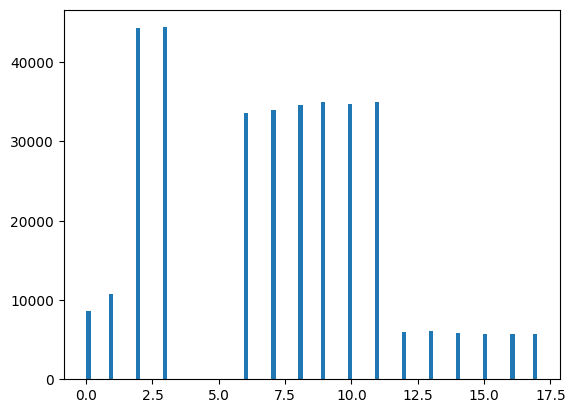

In [196]:
plt.hist( res["digi_layer"],bins=100);

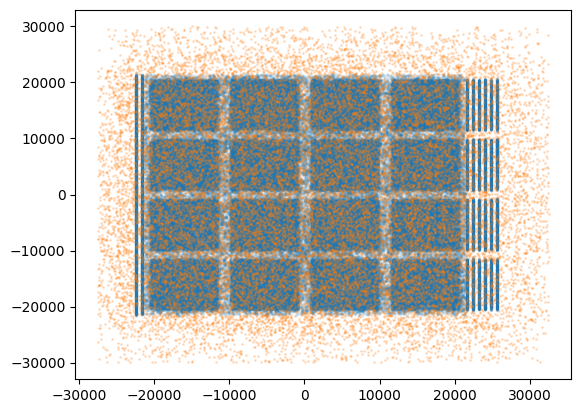

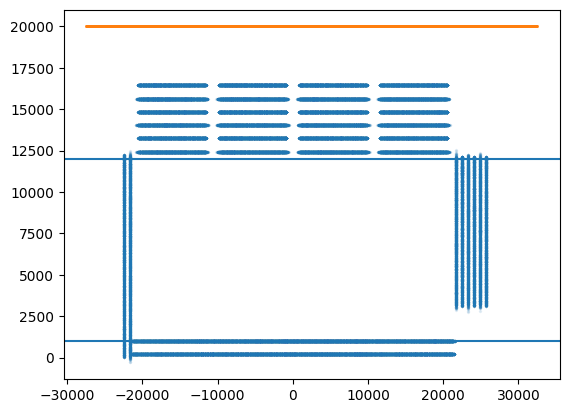

In [209]:
plt.scatter(res["digi_x"], res["digi_y"], s=2, alpha=0.1)
plt.scatter(res["gen_x"], res["gen_y"], s=1, alpha=0.2)
plt.show()

plt.scatter(res["digi_x"], res["digi_z"], s=2, alpha=0.1)
plt.scatter(res["gen_x"], res["gen_z"], s=1, alpha=0.2)
plt.axhline(1000)
plt.axhline(12000)
plt.show()

Text(0.5, 0, 'Momentum [GeV/c]')

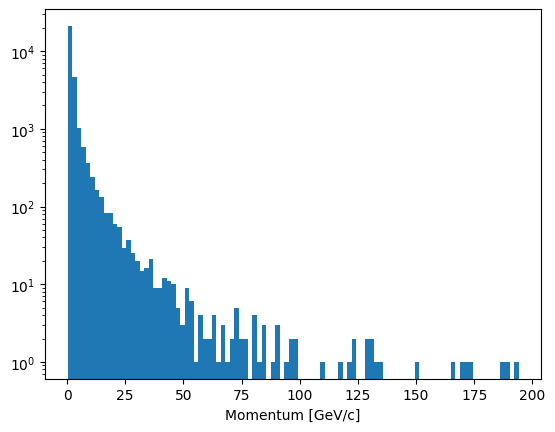

In [204]:
gen_pvec = [res["gen_px"],res["gen_py"],res["gen_pz"]]
gen_pnorm = np.linalg.norm(gen_pvec, axis=0)

plt.hist(gen_pnorm*1e-3,bins=100);
plt.yscale("log")
plt.xlabel("Momentum [GeV/c]")